#2D Convolution (10 points)

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import scipy.io

##Problem 4.1

In [10]:
#input matrix
input = torch.tensor([
    [ 0,  0, -1,  0,  0,  0,  1,  0,  0],
    [ 0, -1, -1, -1,  0,  1,  1,  1,  0],
    [-1, -1, -1, -1,  0,  1,  1,  1,  1],
    [ 0, -1, -1, -1,  0,  1,  1,  1,  0],
    [ 0,  0, -1,  0,  0,  0,  1,  0,  0],
], dtype=torch.float32)

kernel = torch.tensor([
    [ 0, -1/2,  0],
    [-1/2,  1, -1/2],
    [ 0, -1/2,  0]
], dtype=torch.float32)


padding = 1
stride = 1
result = F.conv2d(input.unsqueeze(0).unsqueeze(0), kernel.unsqueeze(0).unsqueeze(0), padding=padding, stride=stride)


print(result.squeeze().numpy())


[[ 0.   1.  -0.5  1.   0.  -1.   0.5 -1.   0. ]
 [ 1.   0.   1.   0.   0.   0.  -1.   0.  -1. ]
 [-0.5  1.   1.   0.5  0.  -0.5 -1.  -1.   0.5]
 [ 1.   0.   1.   0.   0.   0.  -1.   0.  -1. ]
 [ 0.   1.  -0.5  1.   0.  -1.   0.5 -1.   0. ]]


In [11]:
kernel

tensor([[ 0.0000, -0.5000,  0.0000],
        [-0.5000,  1.0000, -0.5000],
        [ 0.0000, -0.5000,  0.0000]])

##Problem 4.2

In [12]:
image = Image.open('/content/puppy-2785074_640.jpg')

In [13]:
transform = transforms.Compose([transforms.ToTensor()])

In [14]:
image = transform(image)

In [15]:
image.shape

torch.Size([3, 427, 640])

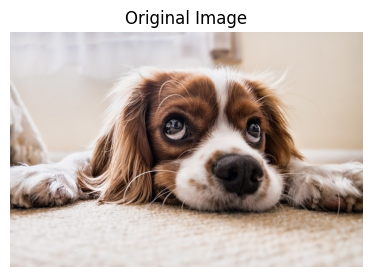

In [16]:
image_np = image.permute(1, 2, 0).numpy()
# Plot the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image_np)
plt.axis('off')

plt.show()

In [17]:
def conv(image, kernel):

    image = F.pad(input=image, pad=(1, 1, 1, 1), value=0)
    output = torch.zeros((3, 427, 640))

    for channel in range(0, 3):
        for i in range(0, 427):
            for j in range(0, 640):
                output[channel, i, j] = torch.tensordot(image[channel, i:3+i, j:3+j], kernel)

    return output

def sum(image):
    sum = image[0, :, :] + image[1, :, :] + image[2, :, :]
    return sum


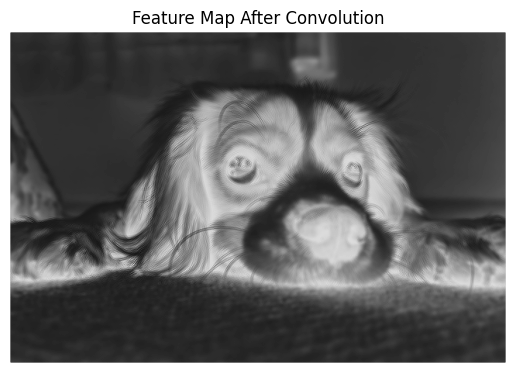

In [18]:
output_image = conv(image, kernel)

# Sum the channels
final_output = sum(output_image)

# Plot the resulting feature map
plt.imshow(final_output, cmap='gray')
plt.title('Feature Map After Convolution')
plt.axis('off')
plt.show()

When the kernel is applied to the image of the dog, results in inversion. This happens because the kernel contains both positive and negative values, and during the convolution operation, these values interact with the pixel values of the image. Specifically, the positive central value amplifies the importance of the central pixel, while the negative values subtract from the surrounding pixels. This combination of operations results in the image appearing inverted or flipped.

#Lab: LMS Algorithm (15 pts)

In [36]:
# Load the .mat file
mat_file = scipy.io.loadmat('dataset.mat')

In [37]:
X = mat_file['X']
D = mat_file['D']

In [38]:
X.shape

(100, 3)

In [39]:
D.shape

(100, 1)

##Problem 5(a)

In [40]:
#Wiener solution
X_transpose = X.T
W = np.linalg.inv(X_transpose.dot(X)).dot(X_transpose).dot(D)

In [41]:
#optimal weight and MSE loss
error=0
for d,x in zip(D,X):
  predicted = np.dot(W.T,x)
  error+=np.square(d-predicted)
  MSE = error/(2*len(D))

print("Optimal Weight (W*):")
print(W)
print("MSE Loss on the Dataset:", MSE)

Optimal Weight (W*):
[[ 1.0006781 ]
 [ 1.00061145]
 [-2.00031968]]
MSE Loss on the Dataset: [5.03995157e-05]


##Problem 5(b)

In [42]:
learning_rate = 0.01
num_epochs = 20
W0 = np.zeros((X.shape[1], 1))

In [43]:
def LMS(num_epochs,learning_rate,W0):
  mse_losses = []
  epoch_values = []
  for epoch in range(num_epochs):
    total_loss = 0.0
    for i in range(X.shape[0]):
        xi = X[i, :].reshape(-1, 1)
        di = D[i, 0]
        predicted = np.dot(xi.T, W0)
        error = di - predicted
        W0 += learning_rate * error * xi
        total_loss += error ** 2


    mse_loss = total_loss / X.shape[0]
    mse_losses.append(mse_loss[0,0])
    epoch_values.append(epoch+1)
  return(mse_losses,W0,epoch_values,xi)

def plot(epoch_value,mse_losses):
  plt.figure(figsize=(6, 6))
  plt.semilogy(epoch_value, mse_losses)
  plt.title("MSE Loss vs. Epochs")
  plt.xlabel("Epochs")
  plt.ylabel("MSE Loss")
  plt.grid(True)
  plt.show()

Learning rate=0.01

In [44]:
mse_losses1,W1,epoch_values1,x1=LMS(20,0.01,np.zeros((X.shape[1], 1)))

In [45]:
print("Optimal Weight for learning rate=0.01:")
print(W1)

Optimal Weight for learning rate=0.01:
[[ 1.00074855]
 [ 1.00082859]
 [-2.00068123]]


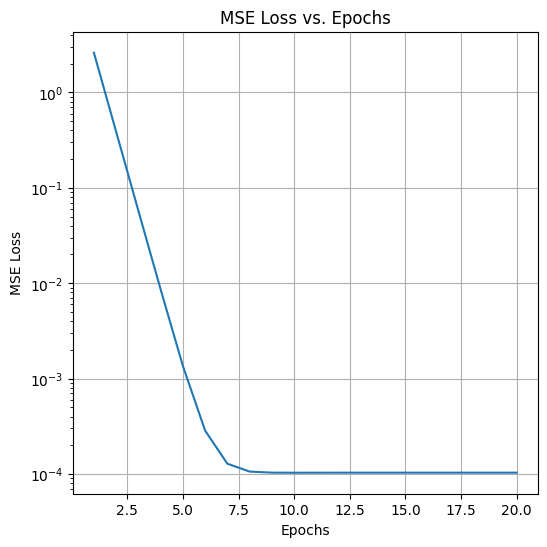

In [46]:
#MSE vs Epochs for learning rate=0.01
plot(epoch_values1,mse_losses1)

##Problem 5(c)

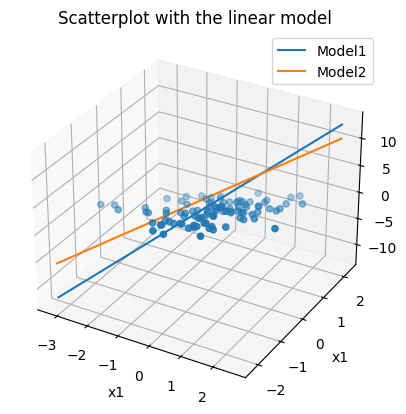

In [70]:
ax = plt.axes(projection='3d')
x1, x2 = X[:, 1], X[:, 2]

ax.scatter3D(x1, x2, D[:, 0])

x1_range = np.linspace(x1.min(), x1.max(), 1000).reshape(-1, 1)
x2_range = np.linspace(x2.min(), x2.max(), 1000).reshape(-1, 1)
X_range = np.concatenate((np.ones((1000, 1)), x1_range, x2_range), axis = 1)

model_1 = np.sum(X_range*W.T, axis = 1).reshape(-1, 1)
ax.plot3D(x1_range, x2_range, model_1, label = 'Model1')

model_2 = np.sum(X_range*W1.T, axis = 1).reshape(-1, 1)
ax.plot3D(x1_range, x2_range, model_2, label = 'Model2')

ax.set_xlabel('x1')
ax.set_ylabel('x1')
ax.set_zlabel('d');
ax.set_title('Scatterplot with the linear model')
ax.legend()

plt.show()

##Problem 5(d)

Learning rate=0.05

Optimal Weight for learning rate=0.005:
[[ 1.00068274]
 [ 1.0006024 ]
 [-2.00033003]]


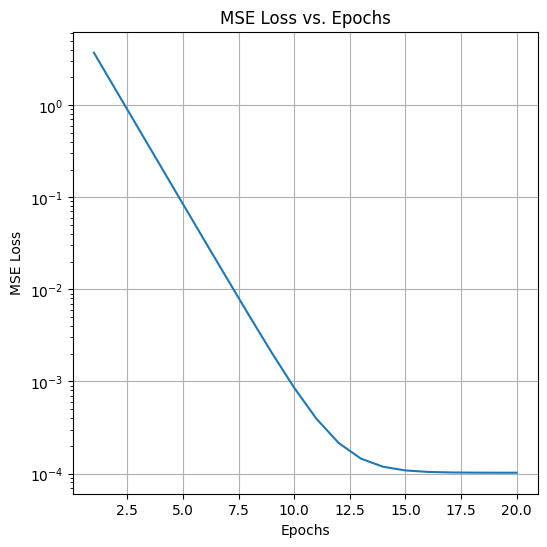

In [ ]:
mse_losses2,W2,epoch_values2,x2=LMS(20,0.005,np.zeros((X.shape[1], 1)))
print("Optimal Weight for learning rate=0.005:")
print(W2)
plot(epoch_values2,mse_losses2)

Learning rate=0.05

Optimal Weight for learning rate=0.05:
[[ 1.00053087]
 [ 1.00163155]
 [-2.00162854]]


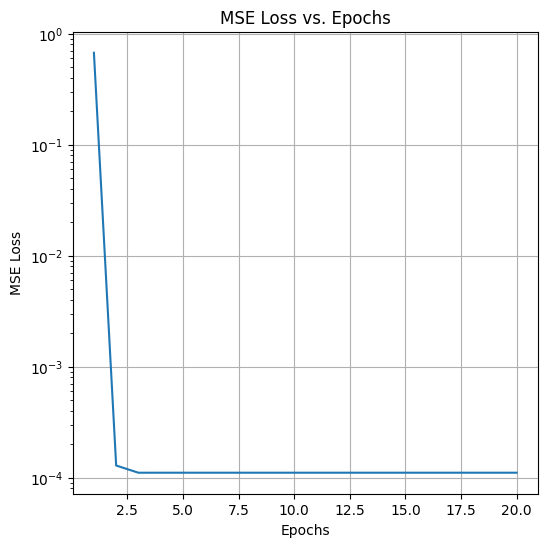

In [ ]:
mse_losses3,W3,epoch_values3,x3=LMS(20,0.05,np.zeros((X.shape[1], 1)))
print("Optimal Weight for learning rate=0.05:")
print(W3)
plot(epoch_values3,mse_losses3)

Learning rate=0.5

Optimal Weight for learning rate=0.5:
[[ 0.97969496]
 [ 0.98520802]
 [-1.9666911 ]]


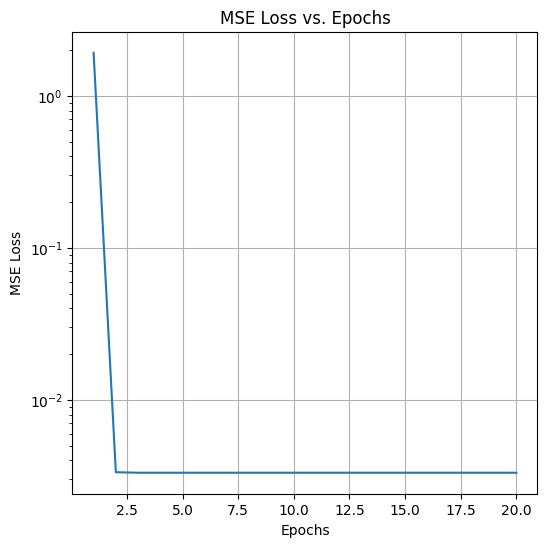

In [ ]:
mse_losses4,W4,epoch_values4,x4=LMS(20,0.5,np.zeros((X.shape[1], 1)))
print("Optimal Weight for learning rate=0.5:")
print(W4)
plot(epoch_values4,mse_losses4)

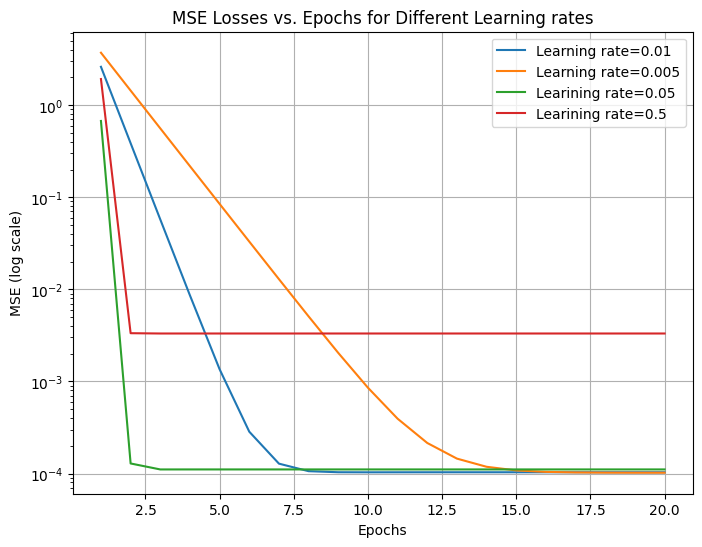

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(epoch_values1, mse_losses1, label='Learning rate=0.01')
ax.plot(epoch_values2, mse_losses2, label='Learning rate=0.005')
ax.plot(epoch_values3, mse_losses3, label='Learining rate=0.05')
ax.plot(epoch_values4, mse_losses4, label='Learining rate=0.5')

ax.set_yscale('log')

ax.set_xlabel('Epochs')
ax.set_ylabel('MSE (log scale)')
ax.set_title('MSE Losses vs. Epochs for Different Learning rates')
ax.legend()


plt.grid(True)
plt.show()

Learning rate=1

In [60]:
mse_losses5,W5,epoch_values5,x5=LMS(16,1,np.zeros((X.shape[1], 1)))


In [61]:
print("MSE values when learning rate=1")
mse_losses5

MSE values when learning rate=1


[7.119582412367745e+16,
 4.620363730740392e+35,
 2.9984681112661684e+54,
 1.945909789411534e+73,
 1.2628331427972737e+92,
 8.195382721362093e+110,
 5.3185409594830484e+129,
 3.4515627761918106e+148,
 2.2399537182751437e+167,
 1.4536582369654892e+186,
 9.433776477867698e+204,
 6.122218852496475e+223,
 3.973123993959127e+242,
 2.578430247546076e+261,
 1.673318666009127e+280,
 1.0859302324270005e+299]

As the learning rate increases, convergence occurs more rapidly, but it must be carefully chosen, as an excessively high learning rate can cause the model to overshoot the minimum.